## Q1. Housing Price (SVM/SVC)

#### Load and Explore the Data

*   Think about standardizing the data.

*  How would you replace discrete attributes


In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
url = "https://drive.google.com/uc?id=1sEtgeWi0lZHFEBvuTi1DcoeqF7TZ-iE1"
df_housing = pd.read_csv(url)
df_housing.head()

,area,land,year,price,bldtype
0,2607,1200,2010,825000.0,0
1,1950,1783,1899,1685000.0,0
2,2520,1875,1899,1100000.0,0
3,3750,3125,1931,1200000.0,1
4,7812,5021,1908,1900000.0,1


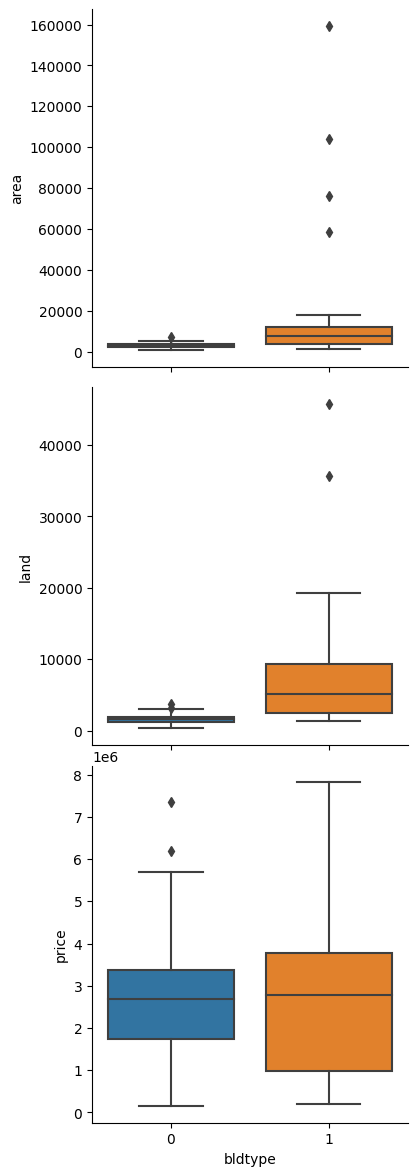

In [3]:
#sns.boxplot(data=df_housing, y='price', x='bldtype')
g = sns.PairGrid(df_housing, x_vars=["bldtype"], y_vars=["area", "land", "price"], height=4)
g.map(sns.boxplot)

The year column represents discrete values and must be seperated into different columns. But there are too many columns for such a small dataset. One solution is to divide the year column into buckets.

In [4]:
# Convert year column into buckets
def convert_into_buckets(ele, min_val, max_val, bucket_size=4):
    x= (max_val - min_val)//bucket_size + 1
    if (ele >= min_val) and (ele < min_val+x):
        return 1
    elif (ele >= min_val+x) and (ele < min_val+2*x):
        return 2
    elif (ele >= min_val+2*x) and (ele < min_val+3*x):
        return 3
    else:
        return 4

df_housing['year_bucket'] = df_housing['year'].apply(lambda x:convert_into_buckets(x, df_housing['year'].min(), df_housing['year'].max()))
df_housing.drop('year', axis=1, inplace=True)
df_housing.head()

,area,land,price,bldtype,year_bucket
0,2607,1200,825000.0,0,4
1,1950,1783,1685000.0,0,2
2,2520,1875,1100000.0,0,2
3,3750,3125,1200000.0,1,3
4,7812,5021,1900000.0,1,2


In [5]:
from sklearn.preprocessing import OneHotEncoder      # Onehot encode the year buckets

enc = OneHotEncoder(drop='first')
df_year = enc.fit_transform(df_housing[['year_bucket']])
df_year = pd.DataFrame(df_year.toarray(), columns=enc.categories_[0][:-1])

In [6]:
df_housing = pd.concat([df_housing, df_year], axis=1).drop('year_bucket', axis=1)
df_housing.head()

,area,land,price,bldtype,1,2,3
0,2607,1200,825000.0,0,0.0,0.0,1.0
1,1950,1783,1685000.0,0,1.0,0.0,0.0
2,2520,1875,1100000.0,0,1.0,0.0,0.0
3,3750,3125,1200000.0,1,0.0,1.0,0.0
4,7812,5021,1900000.0,1,1.0,0.0,0.0


#### Train-Test Split 80/20

In [7]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(df_housing.loc[:, df_housing.columns != 'bldtype'].to_numpy(np.float64), df_housing['bldtype'].to_numpy(np.float64), test_size=0.2, random_state=22)

In [8]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

#### Train a linear model with soft margin



*   Try with initial value of C=1



In [9]:
from sklearn.svm import SVC

model = SVC(C=1.0, kernel='linear')
model.fit(X_train, y_train)
print('Accuracy:', model.score(X_test, y_test))

Accuracy: 0.9473684210526315


#### Use cross validation to find best value of C



*   Can do it manually or use GridSearchCV

*   Divide the training set into train+validation



In [10]:
from sklearn.model_selection import GridSearchCV

params = dict(C = np.linspace(1, 1000, 1000), kernel = ['linear', 'rbf'])
gridSearch = GridSearchCV(SVC(), param_grid=params, cv=4, verbose=3)
gridSearch.fit(X_train, y_train)
gridSearch.score(X_test, y_test)

Fitting 4 folds for each of 2000 candidates, totalling 8000 fits
[CV 1/4] END ..............C=1.0, kernel=linear;, score=0.895 total time=   0.0s
[CV 2/4] END ..............C=1.0, kernel=linear;, score=0.842 total time=   0.0s
[CV 3/4] END ..............C=1.0, kernel=linear;, score=0.789 total time=   0.0s
[CV 4/4] END ..............C=1.0, kernel=linear;, score=0.889 total time=   0.0s
[CV 1/4] END .................C=1.0, kernel=rbf;, score=0.842 total time=   0.0s
[CV 2/4] END .................C=1.0, kernel=rbf;, score=0.842 total time=   0.0s
[CV 3/4] END .................C=1.0, kernel=rbf;, score=0.684 total time=   0.0s
[CV 4/4] END .................C=1.0, kernel=rbf;, score=0.722 total time=   0.0s
[CV 1/4] END ..............C=2.0, kernel=linear;, score=0.895 total time=   0.0s
[CV 2/4] END ..............C=2.0, kernel=linear;, score=0.842 total time=   0.0s
[CV 3/4] END ..............C=2.0, kernel=linear;, score=0.789 total time=   0.0s
[CV 4/4] END ..............C=2.0, kernel=lin

1.0

In [11]:
model = SVC(C=gridSearch.best_params_['C'], kernel=gridSearch.best_params_['kernel'])
model.fit(X_train, y_train)
print('Accuracy:', model.score(X_test, y_test))
print('SVC Best Params:', gridSearch.best_params_)

Accuracy: 1.0
SVC Best Params: {'C': 10.0, 'kernel': 'linear'}


#### Analyse accuracy basis the new values you have computed

<i>Answer:</i> Initially, we get an accuracy of around 94%. Then we use GridSearchCV to tune the hyperparameter C which gives an optimal value of C=10.0 and also performs well on the test set giving 100% test accuracy.

## Q2. DT and RF

Consider the Wisconsin Breast Cancer dataset available from
http://archive.ics.uci.edu/ml/datasets/Breast+Cancer+Wisconsin+
(Diagnostic)

The dataset has 32 attributes that predict malignancy. There are a
total of 569 data patterns. Use 5-fold cross-validation. 


1.   Use Keras or any other framework to construct a decision tree from the training data and obtain the performance on the test data

2.   Construct a random forest (of say, 100 trees) from the training data and use the random forest to obtain the performance on the test data

3. Compare the performance you obtain in 1 and 2


In [12]:
names = ['id','diagnosis','radius_mean','texture_mean','perimeter_mean','area_mean','smoothness_mean','compactness_mean','concavity_mean','concave points_mean','symmetry_mean','fractal_dimension_mean','radius_se','texture_se','perimeter_se','area_se','smoothness_se','compactness_se','concavity_se','concave points_se','symmetry_se','fractal_dimension_se','radius_worst','texture_worst','perimeter_worst','area_worst','smoothness_worst','compactness_worst','concavity_worst','concave points_worst','symmetry_worst','fractal_dimension_worst']
df_wisconsin = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/breast-cancer-wisconsin/wdbc.data', names=names)
df_wisconsin.columns = names
df_wisconsin.head()

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


In [13]:
df_wisconsin.drop('id', axis=1, inplace=True)
df_wisconsin['diagnosis'] = df_wisconsin['diagnosis'].apply(lambda x:1 if x=='M' else 0)
df_wisconsin.head()

,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,1,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,1,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,1,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,1,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


In [14]:
print('Correlations:', df_wisconsin.corr()['diagnosis'])

Correlations: diagnosis                  1.000000
radius_mean                0.730029
texture_mean               0.415185
perimeter_mean             0.742636
area_mean                  0.708984
smoothness_mean            0.358560
compactness_mean           0.596534
concavity_mean             0.696360
concave points_mean        0.776614
symmetry_mean              0.330499
fractal_dimension_mean    -0.012838
radius_se                  0.567134
texture_se                -0.008303
perimeter_se               0.556141
area_se                    0.548236
smoothness_se             -0.067016
compactness_se             0.292999
concavity_se               0.253730
concave points_se          0.408042
symmetry_se               -0.006522
fractal_dimension_se       0.077972
radius_worst               0.776454
texture_worst              0.456903
perimeter_worst            0.782914
area_worst                 0.733825
smoothness_worst           0.421465
compactness_worst          0.590998
concavity_wors

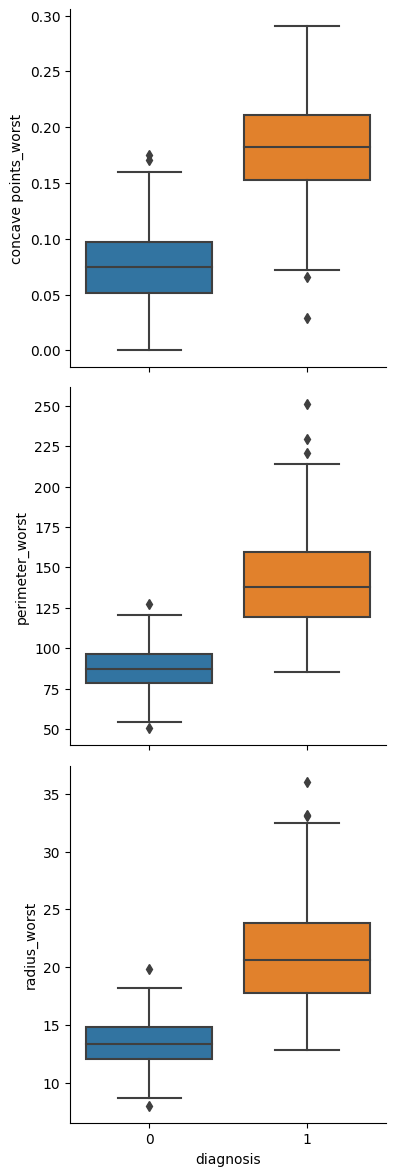

In [15]:
g = sns.PairGrid(df_wisconsin, x_vars=["diagnosis"], y_vars=["concave points_worst", "perimeter_worst", "radius_worst"], height=4)
g.map(sns.boxplot)

In [16]:
# Remove the last 5 unrelated columns (Since the correlation is less than 0.01)
df_wisconsin = df_wisconsin[df_wisconsin.corr()['diagnosis'].sort_values(ascending=False)[:-5].index]

In [17]:
X_train_cancer, X_test_cancer, y_train_cancer, y_test_cancer = train_test_split(df_wisconsin.loc[:, df_wisconsin.columns != 'diagnosis'].to_numpy(np.float64), df_wisconsin['diagnosis'].to_numpy(np.float64), random_state=42)

In [18]:
# Create a pipeline to scale and tune the hyperparameters together
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import make_pipeline

pipe = make_pipeline(StandardScaler(), DecisionTreeClassifier(splitter='best', criterion='gini', max_depth=100))

params_wisc = dict(decisiontreeclassifier__criterion=['gini', 'entropy'], decisiontreeclassifier__max_depth=list(range(100,200)))
gridSearchWisconsin = GridSearchCV(pipe, param_grid=params_wisc, cv=5, n_jobs=-1, verbose=3)
gridSearchWisconsin.fit(X_train_cancer, y_train_cancer)
print('Decision Tree Accuracy:', gridSearchWisconsin.score(X_test_cancer, y_test_cancer))

Fitting 5 folds for each of 200 candidates, totalling 1000 fits
Decision Tree Accuracy: 0.9440559440559441


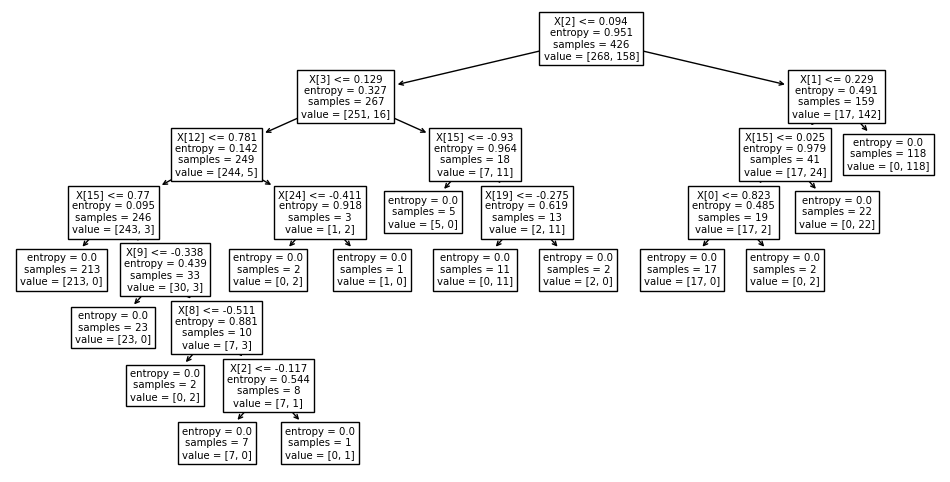

In [19]:
from sklearn.tree import plot_tree
plt.figure(figsize=(12,6))
plot_tree(gridSearchWisconsin.best_estimator_['decisiontreeclassifier'])
pass

In [20]:
from sklearn.ensemble import RandomForestClassifier

pipe_rf = make_pipeline(StandardScaler(), RandomForestClassifier(n_estimators=100, criterion='gini', max_depth=200))

params_wisc_rf = dict(randomforestclassifier__n_estimators=list(range(100, 120)), randomforestclassifier__max_depth=list(range(190, 200)))
gridSearchWisconsinRf = GridSearchCV(pipe_rf, param_grid=params_wisc_rf, cv=5, n_jobs=-1, verbose=3)
gridSearchWisconsinRf.fit(X_train_cancer, y_train_cancer)
print('Random Forest Accuracy:', gridSearchWisconsinRf.score(X_test_cancer, y_test_cancer))

Fitting 5 folds for each of 200 candidates, totalling 1000 fits
Random Forest Accuracy: 0.965034965034965


In [21]:
print('Random Forest Best Params:', gridSearchWisconsinRf.best_params_)

Random Forest Best Params: {'randomforestclassifier__max_depth': 190, 'randomforestclassifier__n_estimators': 106}


####  Repeat the exercise but add ±10% noise to 25% of the data (Optional)

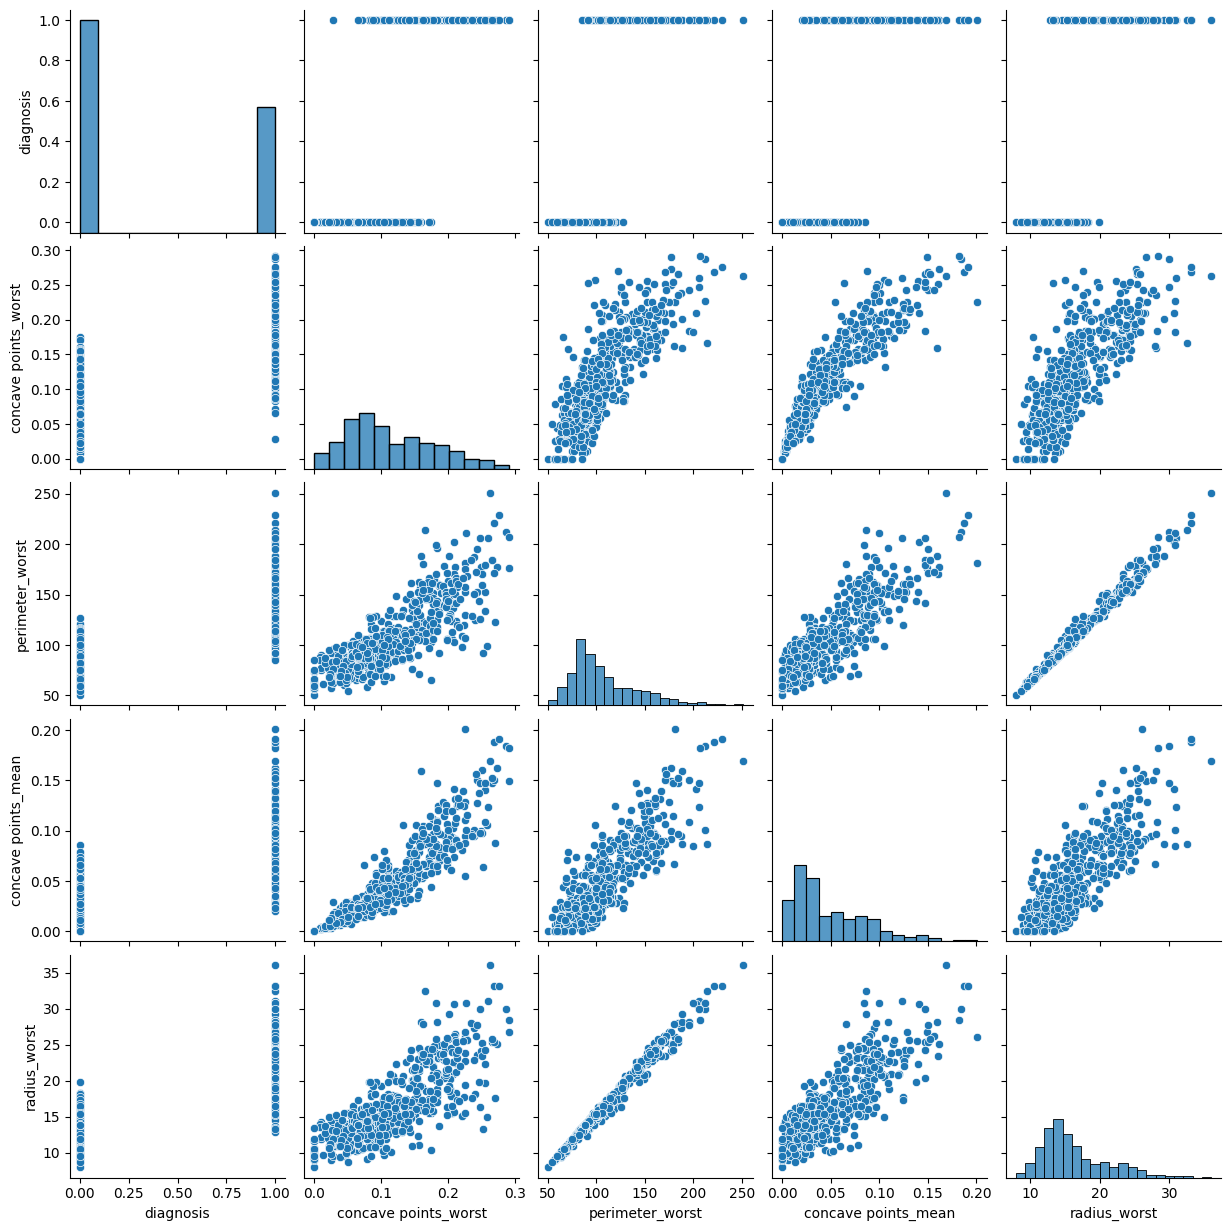

In [22]:
sns.pairplot(df_wisconsin.iloc[:,:5])

In [23]:
# Generate noise from the same data distribution by scaling it to 10% and picking the 25% of the data at random
noise = np.apply_along_axis(lambda x:np.random.normal(np.mean(x), np.std(x), x.size)*0.1, 0, X_train_cancer)
np.random.shuffle(noise)
noise = noise[:int(.25*X_train_cancer.shape[0])]
X_train_cancer_noisy = X_train_cancer.copy()
X_train_cancer_noisy[:int(.25*X_train_cancer_noisy.shape[0]),:]+=noise

In [24]:
pipe_rfn = make_pipeline(StandardScaler(), RandomForestClassifier(n_estimators=100, criterion='gini', max_depth=200))

gridSearchWisconsinRfn = GridSearchCV(pipe_rf, param_grid=params_wisc_rf, cv=5, n_jobs=-1, verbose=3)
gridSearchWisconsinRfn.fit(X_train_cancer_noisy, y_train_cancer)
print('Random forest on noisy data:', gridSearchWisconsinRfn.score(X_test_cancer, y_test_cancer))

Fitting 5 folds for each of 200 candidates, totalling 1000 fits
Random forest on noisy data: 0.972027972027972


Accuracy increases as we add noise possibly because it acts as regularizer and reduces overfitting.

### Boosting

Implement a boosting classifier algorithm for the same dataset as above (sample without noise)

Feel free to use any boosting algorithm you want

However only run the code for the eventual algorithm you choose and comment out every other algorithm

Briefly explain why you chose a particular algorithm

In [25]:
from sklearn.ensemble import AdaBoostClassifier

pipe_adb = make_pipeline(StandardScaler(), AdaBoostClassifier(n_estimators=1000, learning_rate=10.0))

params_wisc_adb = dict(adaboostclassifier__n_estimators=list(range(50, 100)), adaboostclassifier__learning_rate=[0.1, 1.0, 10.0])
gridSearchWisconsinAdb = GridSearchCV(pipe_adb, param_grid=params_wisc_adb, cv=5, n_jobs=-1, verbose=3)
gridSearchWisconsinAdb.fit(X_train_cancer, y_train_cancer)
print('Adaboost Score:', gridSearchWisconsinAdb.score(X_test_cancer, y_test_cancer))
print('Adaboost best params:', gridSearchWisconsinAdb.best_params_)

Fitting 5 folds for each of 150 candidates, totalling 750 fits
Adaboost Score: 0.958041958041958
Adaboost best params: {'adaboostclassifier__learning_rate': 1.0, 'adaboostclassifier__n_estimators': 61}


Q: Why did we choose the AdaBoost Algorithm? <br><br>
A: AdaBoost is relatively robust to overfitting in low noise datasets and gives the highest accuracy score as with time it gives more weightage to even the mis-classified data points which increases its overall accuracy. Thus, even though Adaboost is slower than XGradient Boost (or Histogram Gradient Boost), it performs well in this case.

In [26]:
'''
from sklearn.ensemble import GradientBoostingClassifier

pipe_gb = make_pipeline(StandardScaler(), GradientBoostingClassifier(n_estimators=1000, learning_rate=10.0))
params_wisc_gb = dict(gradientboostingclassifier__n_estimators=list(range(50, 100)), gradientboostingclassifier__learning_rate=[0.1, 1.0, 10.0])
gridSearchWisconsinGb = GridSearchCV(pipe_gb, param_grid=params_wisc_gb, cv=5, n_jobs=-1, verbose=3)
gridSearchWisconsinGb.fit(X_train_cancer, y_train_cancer)
print('Gradient Boosting Score:', gridSearchWisconsinGb.score(X_test_cancer, y_test_cancer))
print('Gradient Boosting Best Params:', gridSearchWisconsinGb.best_params_)
'''
pass

In [27]:
from sklearn.ensemble import HistGradientBoostingClassifier

pipe_hgb = make_pipeline(StandardScaler(), HistGradientBoostingClassifier(max_depth=200, learning_rate=10.0))
params_wisc_hgb = dict(histgradientboostingclassifier__max_depth=list(range(150, 160)), histgradientboostingclassifier__learning_rate=[0.1, 1.0, 10.0])
gridSearchWisconsinHgb = GridSearchCV(pipe_hgb, param_grid=params_wisc_hgb, n_jobs=-1, cv=5, verbose=3)
gridSearchWisconsinHgb.fit(X_train_cancer, y_train_cancer)
print('Histogram Gradient Boosting Score:', gridSearchWisconsinHgb.score(X_test_cancer, y_test_cancer))
print('Histogram Gradient Boosting Best Params:', gridSearchWisconsinHgb.best_params_)

Fitting 5 folds for each of 30 candidates, totalling 150 fits
Histogram Gradient Boosting Score: 0.951048951048951
Histogram Gradient Boosting Best Params: {'histgradientboostingclassifier__learning_rate': 1.0, 'histgradientboostingclassifier__max_depth': 150}


### Bagging

Implement a bagging classifier on the RF you created above


> from sklearn.ensemble import BaggingClassifier

You will have to pass the DT into the Bagging Classifier

Once you have the y_pred for Bagging and RF, accurately compute the accuracy by computing the numpy sum where pred(bagging) == pred(RF) and divide by len(pred(bagging))

Please provide rationale behind why this is done.



In [28]:
from sklearn.ensemble import BaggingClassifier
# hyper parameters
bag_n_estimators = list(range(150, 500, 50))

#Parameters for Hyperparameter tuning
bag_params = [{'n_estimators' : bag_n_estimators,
                'max_samples' : [0.05, 0.1, 0.2, 0.5]}]

#Passing Decision Tree to 
bagging_model = BaggingClassifier(DecisionTreeClassifier(ccp_alpha= gridSearchWisconsin.best_estimator_['decisiontreeclassifier'].ccp_alpha,
                                criterion= gridSearchWisconsin.best_estimator_['decisiontreeclassifier'].criterion,
                                max_depth= gridSearchWisconsin.best_estimator_['decisiontreeclassifier'].max_depth,
                                max_features= gridSearchWisconsin.best_estimator_['decisiontreeclassifier'].max_features,
                                min_samples_leaf= gridSearchWisconsin.best_estimator_['decisiontreeclassifier'].min_samples_leaf,
                                min_samples_split= gridSearchWisconsin.best_estimator_['decisiontreeclassifier'].min_samples_split, 
                                random_state=42)) 


bagging_clf = GridSearchCV(bagging_model, param_grid=bag_params, verbose=3, n_jobs=-1)

In [29]:
#Fitting the training data
bagging_clf.fit(X_train_cancer, y_train_cancer)

#Predicting using the test data
y_pred_bagging = bagging_clf.predict(X_test_cancer)
predictions_rf = gridSearchWisconsinRf.predict(X_test_cancer)

Fitting 5 folds for each of 28 candidates, totalling 140 fits


In [30]:
#Accuracy of the model
print("Bagging Accuracy Comparison with Random Forest Classifier:", (np.sum(y_pred_bagging == predictions_rf))/len(y_pred_bagging))

Bagging Accuracy Comparison with Random Forest Classifier: 1.0


<i>Ques:</i> Please provide rationale behind why this is done.

<i>Answer:</i> The rationale behind this is that Random Forest is a combination of several Decision Trees with Bagging. Hence, the predicitons of Bagging Classifier with Decision trees should be closely matched with the Random Forest predictons as obtained above.

Bonus : While you are looking at ensemble models, explore VotingClassifier

In [31]:
from sklearn.ensemble import VotingClassifier

models = [('rf', gridSearchWisconsinRf.best_estimator_['randomforestclassifier']), ('adb', gridSearchWisconsinAdb.best_estimator_['adaboostclassifier']),
('hgb', gridSearchWisconsinHgb.best_estimator_['histgradientboostingclassifier']), ('bg', bagging_clf.best_estimator_)]

pipe_vc = make_pipeline(StandardScaler(), VotingClassifier(estimators=models, voting='soft'))
params_wisc_vc = dict(votingclassifier__voting=['hard', 'soft'])
gridSearchWisconsinVc = GridSearchCV(pipe_vc, param_grid=params_wisc_vc, n_jobs=-1, cv=5, verbose=3)
gridSearchWisconsinVc.fit(X_train_cancer, y_train_cancer)
print('Voting classifier Accuracy:', gridSearchWisconsinVc.score(X_test_cancer, y_test_cancer))

Fitting 5 folds for each of 2 candidates, totalling 10 fits
Voting classifier Accuracy: 0.965034965034965
